# Lesson 2 Practice - Face Masks Usage

In an attempt to slow down the spread of the novel coronavirus, an increasing number of countries have made wearing face masks mandatory in public spaces, with citizens facing a possible fine if caught without one.

One problem many small business face is about ensuring everyone entering their space correctly uses a face mask and/or a face shield. Its part of some people's jobs to be at the entry of their business just looking at people.

To face this problem I'll build a model capable of identifying if a person is wearing a mask, a face shield or no mask, furthermore, I want to try building a model capable of telling if the a person is wrongly wearing a mask.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import fast.ai library:

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate

## Creating the DataBunch

The dataset used is composed of 5 different classes:
    - With mask;
    - With face shield and without mask;
    - With face shield and mask;
    - With mask incorrectly worn;
    - No Protection (neither mask, neiter face shield.
    
To build this dataset I used a mixture of googling and one dataset from [kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection):
    - Manually searched for several related terms. Had to pick the images by hand since finding some of the classes was difficult and not very examples were found (specially for masks incorrectly worn);
    - Used the dataset present on Kaggle but had to crop some images because some of them were of several people.

In [21]:
path = "/notebooks/storage/masks-dataset"

Create the DataBunch using the factory *.from_folder*. Set the valid_pct to 0.2 - 20% of the set will be the validation set. Specicy the size as 224 - this resizes but and crops the images to squares.

You can use the seed number,  if needed, I'll not use in this case.

In [25]:
#np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [58]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [26]:
data.classes

['face-mask',
 'face-shield-with-mask',
 'face-shield-without-mask',
 'incorrect-face-mask-usage',
 'no-mask']

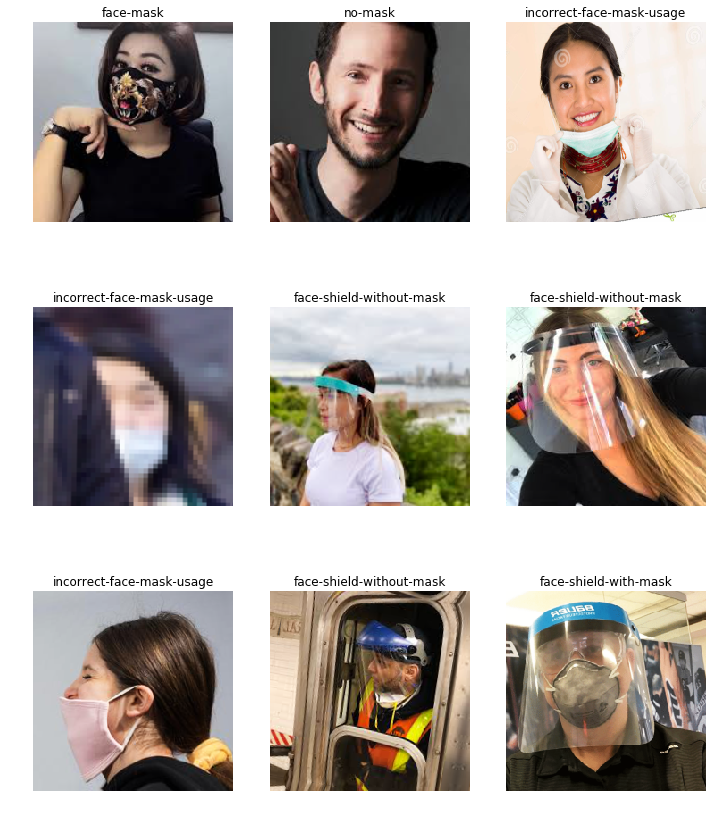

In [27]:
data.show_batch(rows=3, figsize=(10,12))

## Train the Model

For the first attempt a **Resnet34** CNN will be used and we'll train for 4 epochs.

In [59]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [60]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.256172,1.367134,0.484536,00:09
1,1.502794,0.452753,0.175258,00:08
2,1.143736,0.382984,0.123711,00:08
3,0.909601,0.385619,0.123711,00:07


In [61]:
learn.save('stage-1')

## Unfreezing, Fine-tuning, and Learning Rates

We will unfreeze the model, plot the Learning Rate vs. the Loss and choose a set of learning rate values where the Loss is not diverging. This bracket of learning rates will be used to train our model through two more epochs.

In [62]:
learn.unfreeze()

In [63]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


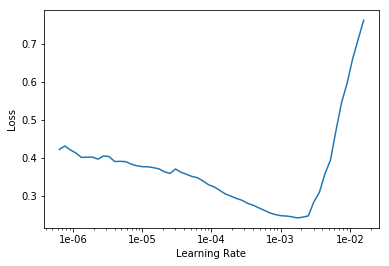

In [64]:
# If the plot is not showing or you want to specify the plot x-axis limits use:
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [69]:
learn.fit_one_cycle(2, max_lr=slice(2e-5,5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.154840,0.387951,0.103093,00:09


In [66]:
learn.save('stage-2')

The model produced a fairly low error rate - 10% - for the amount of data available (only about 100 images per classe).

## Results

Firstly we will see the top losses, i.e., the images where the model was very confident but wrongly labeled the image. Were these cases fairly easy for a human to distinguish?

We will use a confusion matrix to understand if classe was being consistently missidentified by other.

In [36]:
interp = ClassificationInterpretation.from_learner(learn)

Show the top nine losses. The values presented above each image are the Prediction/Actual/Loss/Probability. 

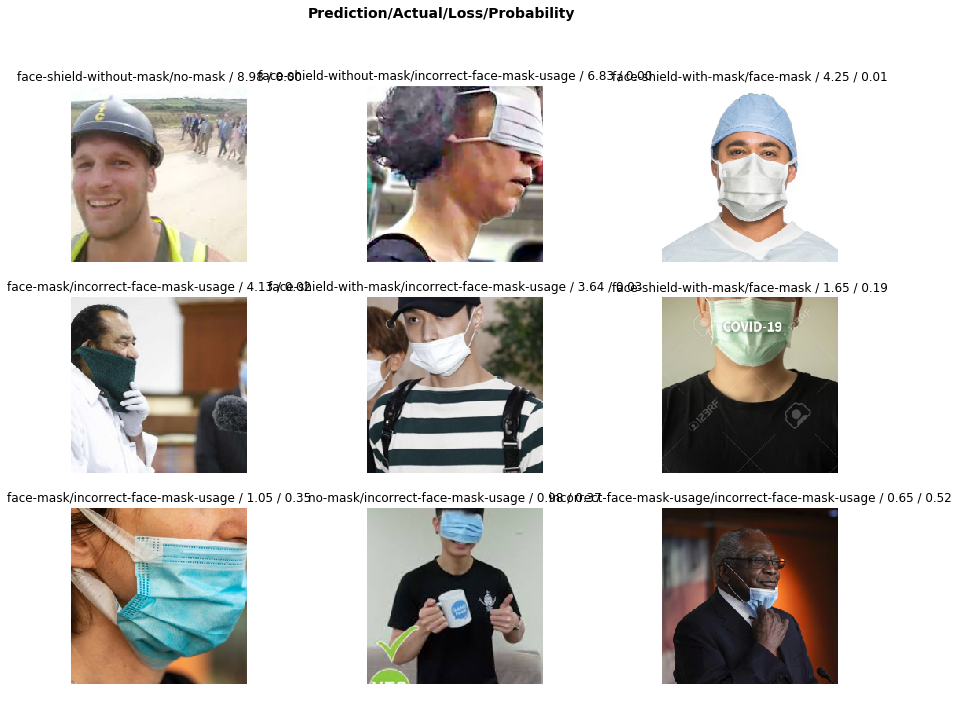

In [39]:
interp.plot_top_losses(9, figsize=(15,11))

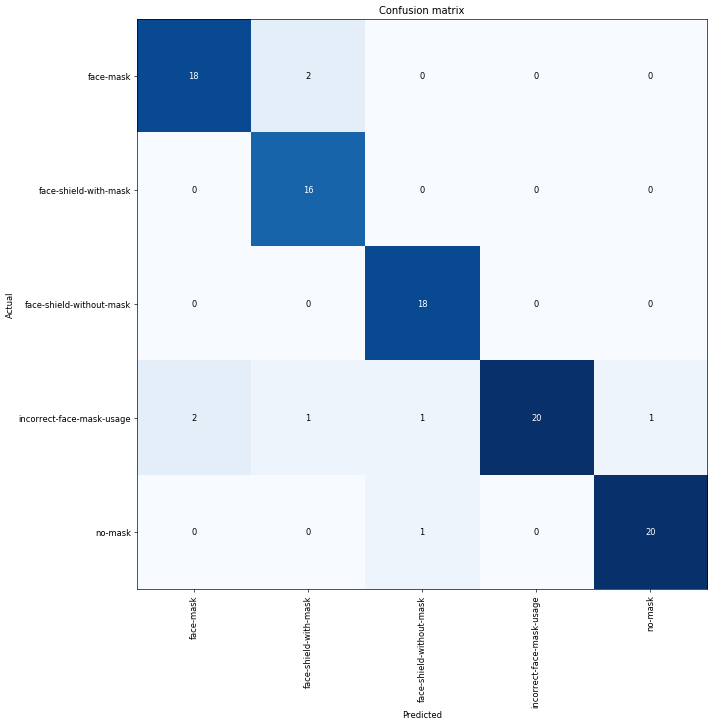

In [40]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [41]:
interp.most_confused(min_val=2)

[('face-mask', 'face-shield-with-mask', 2),
 ('incorrect-face-mask-usage', 'face-mask', 2)]

As it could be expected the main strugle of the model is to distinguish between the someone using a mask correctly and using it incorrectly. The difference between these can be very subtle, nose out is enough to be wrongly worn.

Also, the difference between using a mask with a face shield or without a face shield can be difficult to distinguish since the face shield are transparent and only some light reflections are visible. 

## Cleaning up

On some datasets we could find wrongly identified images and therefore they make the life harder to train.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [43]:
from fastai.widgets import *

In [47]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [52]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [53]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [54]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [57]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

# db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
#                    .split_none()
#                    .label_from_df()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )

In [55]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [56]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Now that we cleaned the dataset let's return to the begining of the notebook and recreate the 'ImageDataBunch' using '.from_csv' with the cleaned.csv file. Then we shall retrain the model.

# Putting the model in production

Let's export the content of our Learner object for production:

In [67]:
learn.export()

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [68]:
defaults.device = torch.device('cpu')

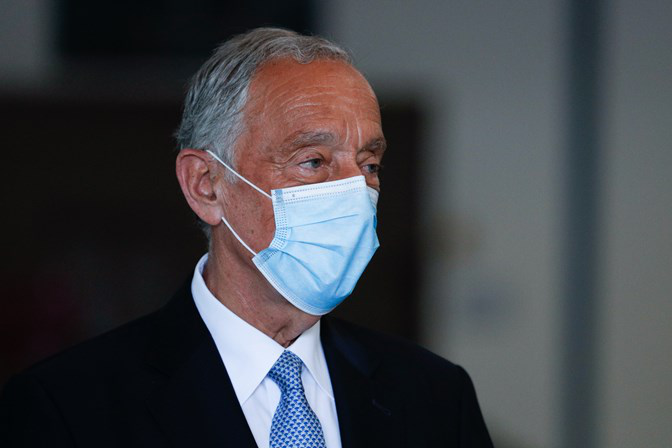

In [78]:
img = open_image('/notebooks/storage/marcelo-rebelo-de-sousa-covid.jpg')
img

In [79]:
learn = load_learner(path)

In [80]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'face-mask'